In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [2]:
image_path_train = "IndustryBiscuitLotus/TRAIN"
image_path_ok = "IndustryBiscuitLotus/OK"
image_path_nok = "IndustryBiscuitLotus/NOK"

In [3]:
image_path_train = "marble/train/good"
image_path_ok = "marble/test/good"
image_path_nok = "marble/test/crack/"

In [4]:
IMAGE_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {DEVICE}.")

The device is cpu.


In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 16 -> 8
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.Sigmoid(),  # output in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])


In [7]:
from torchvision.io import read_image

class CookieImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.image_names = os.listdir(self.img_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_names[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [8]:
train_dataset = CookieImageDataset(image_path_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs in train_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    mean_loss = total_loss/len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {mean_loss:.6f}")
    losses.append(mean_loss)


Epoch [1/20], Loss: 0.019639
Epoch [2/20], Loss: 0.003801
Epoch [3/20], Loss: 0.001053
Epoch [4/20], Loss: 0.000540
Epoch [5/20], Loss: 0.000374
Epoch [6/20], Loss: 0.000329
Epoch [7/20], Loss: 0.000313
Epoch [8/20], Loss: 0.000271
Epoch [9/20], Loss: 0.000248
Epoch [10/20], Loss: 0.000231
Epoch [11/20], Loss: 0.000224
Epoch [12/20], Loss: 0.000213
Epoch [13/20], Loss: 0.000212
Epoch [14/20], Loss: 0.000192
Epoch [15/20], Loss: 0.000203
Epoch [16/20], Loss: 0.000187
Epoch [17/20], Loss: 0.000187
Epoch [18/20], Loss: 0.000177
Epoch [19/20], Loss: 0.000178
Epoch [20/20], Loss: 0.000177


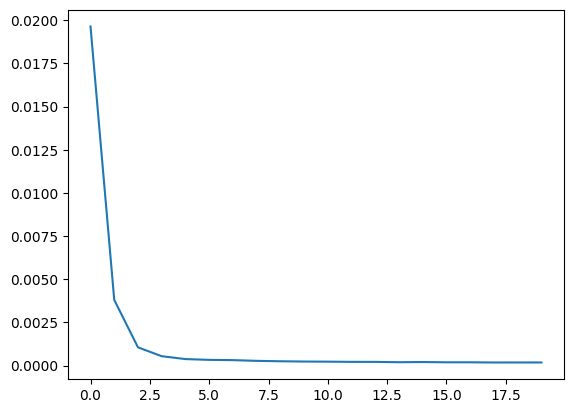

In [11]:
plt.plot(losses)

In [12]:
def compare_orig_and_reconstructed(orig, recon):
    # Optional: visualize
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(np.transpose(orig[0], (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed")
    plt.imshow(np.transpose(recon[0], (1, 2, 0)))
    plt.show()

In [13]:
def compute_reconstruction_error(img_path):
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
    loss = criterion(output, img_tensor).item()
    return loss, img_tensor.cpu(), output.cpu()


Reconstruction error: 0.0003


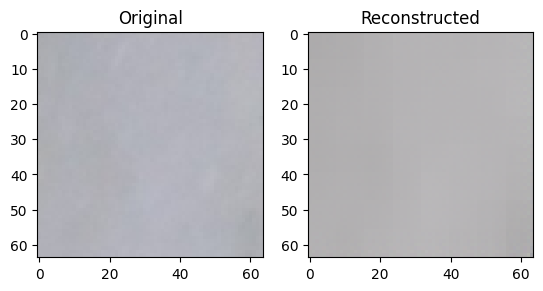

Reconstruction error: 0.0088


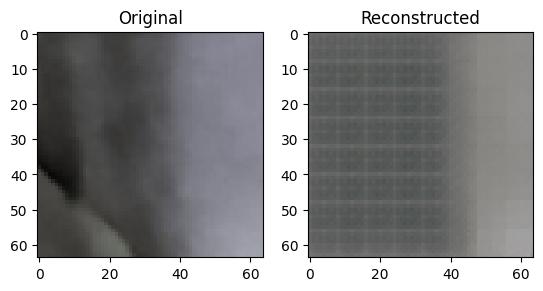

Reconstruction error: 0.0009


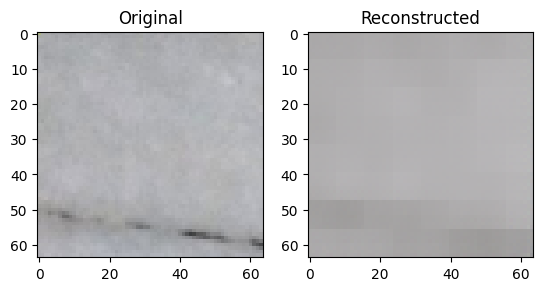

Reconstruction error: 0.0003


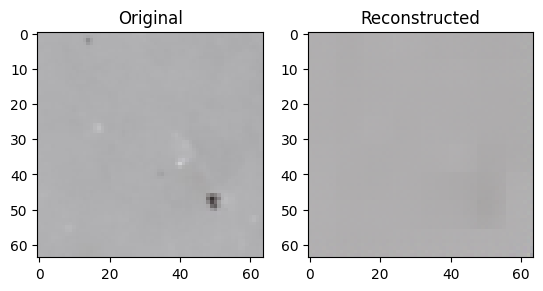

In [14]:
# Example
error, orig, recon = compute_reconstruction_error("marble/test/good/_0_0_20210525_15434.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

error, orig, recon = compute_reconstruction_error("marble/test/crack/_0_0_20210531_17292_0.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

error, orig, recon = compute_reconstruction_error("marble/test/joint/_0_4352_20210525_15441_1.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

error, orig, recon = compute_reconstruction_error("marble/test/dot/_0_2560_20210531_10521_2.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon)

In [19]:
from numpy import mean, std


def compute_mean_reconstruction_error(image_path, error_thresh = None):
    recon_errors = []
    for file_name in os.listdir(image_path):
        error, orig, recon = compute_reconstruction_error(os.path.join(image_path, file_name))
        if error_thresh is not None:
            if error > error_thresh:
                print(error)
                compare_orig_and_reconstructed(orig, recon)
        recon_errors.append(error)
    return mean(recon_errors), min(recon_errors), max(recon_errors)

0.0014346471289172769


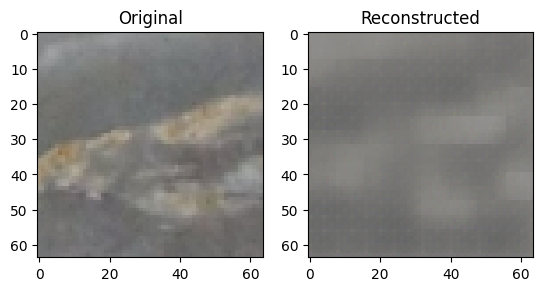

0.0016056265449151397


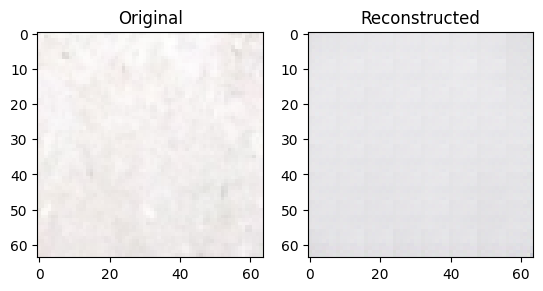

(np.float64(0.00018707769353675438), 2.723617944866419e-05, 0.0016056265449151397)
(np.float64(0.002558133225965861), 8.312162390211597e-05, 0.028470637276768684)
(np.float64(0.0017725868771473567), 9.508104267297313e-05, 0.00671426160261035)
(np.float64(0.0010313227518660522), 0.00011568633635761216, 0.004782580770552158)


In [21]:
print(compute_mean_reconstruction_error("marble/test/good", 0.001))
print(compute_mean_reconstruction_error("marble/test/crack"))
print(compute_mean_reconstruction_error("marble/test/joint"))
print(compute_mean_reconstruction_error("marble/test/dot"))